# Converge of the Standard Deviation of the Delta Hedging Error

## Introduction

This notebook runs a simple delta hedging simulation. The underlying asset follows a geometric Brownian motion of the form

$$
\mathrm{d}S_t = r S_t \mathrm{d}t + \sigma S_t \mathrm{d}W_t.
$$

We initially sell a European plain vanilla option and enter a hedge delta. We then periodically, after equally spaced intervals, re-adjust the delta hedge. As the number of steps becomes large (the re-hedging frequency becomes small), the standard deviation of the hedging error tends to zero.

In [2]:
import numpy
import scipy.stats as stats
import matplotlib.pyplot as pyplot
%matplotlib inline

In [90]:
# contract data
maturity = 1.0
strike = 100.0
isCall = True

# market dataa
spot = 100.0
rate = 0.05
volatility = 0.2

# simulation settings
pathCount = 1000

## Vanilla Pricer

Simple European plain vanilla pricer that returns the option price and delta.

In [91]:
def vanillaBlackScholes(maturity, spot):
    totalVolatility = volatility * numpy.sqrt(maturity)
    discountFactor = numpy.exp(-rate * maturity)
    forward = spot / discountFactor
    dPlus = numpy.log(forward / strike) / totalVolatility + 0.5 * totalVolatility
    dMinus = dPlus - totalVolatility
    callPutFlag = 1.0 if isCall else -1.0
    dPlusCDF = stats.norm.cdf(callPutFlag * dPlus)
    dMinusCDF = stats.norm.cdf(callPutFlag * dMinus)
    price = callPutFlag * discountFactor * (forward * dPlusCDF - strike * dMinusCDF)
    delta = callPutFlag * dPlusCDF
    return (price, delta)

## Hedging Simulation

We simulate the evolution of the bank account balance $\Phi_B(t)$ and the position in the underlying asset $\Phi_S(t)$. Initially, we set

\begin{eqnarray*}
\Phi_B(0) & = & \left( V(0) - \Delta(0) S(0) \right),\\
\Phi_S(0) & = & \Delta(0),
\end{eqnarray*}

where $V(0)$ and $\Delta(0)$ are the option price and delta, respectively. At time $t_i$, we update the position by

\begin{eqnarray*}
\Phi_B \left( t_i \right) & = & \Phi_B \left( t_{i - 1} \right) e^{r \Delta t} - \left( \Delta \left( t_i \right) - \Delta \left( t_{i - 1} \right) \right) S \left( t_i \right)\\
\Phi_S \left( t_i \right) & = & \Delta \left( t_i \right)
\end{eqnarray*}

In [92]:
def simulateHedgingError(stepCount):
    deltaT = maturity / float(stepCount)
    stepDrift = (rate - 0.5 * volatility * volatility) * deltaT
    stepDiffusion = volatility * numpy.sqrt(deltaT)
    stepCompoundFactor = numpy.exp(rate * deltaT)
    
    # setup initial spots, balances and positions
    spots = numpy.ones(pathCount) * spot
    price, delta = vanillaBlackScholes(maturity, spot)
    balances = numpy.ones(pathCount) * (price - delta * spot)
    positions = numpy.ones(pathCount) * delta    
    # run the simulation
    for i in range(stepCount):
        currentTime = numpy.minimum((i + 1) * deltaT, maturity)
        currentMaturity = maturity - currentTime
        balances *= stepCompoundFactor
        spots *= numpy.exp(stepDrift + stepDiffusion * numpy.random.normal(0.0, 1.0, pathCount))
        
        # re-adjust the hedge (except for at maturity)
        if (i != stepCount - 1):
            prices, deltas = vanillaBlackScholes(currentMaturity, spots)
            balances -= (deltas - positions) * spots
            positions = deltas
    
    # compute the payoffs and hedged p&l
    callPutFlag = 1.0 if isCall else -1.0
    payoffs = numpy.maximum(callPutFlag * (spots - strike), 0.0)
    hedgeValues = balances + positions * spots
    hedgeErrors = hedgeValues - payoffs
    mean = numpy.mean(hedgeErrors)
    standardDeviation = numpy.std(hedgeErrors)
    return (mean, standardDeviation)

In [93]:
stepCounts = range(1, 100)
simulationResults = [simulateHedgingError(stepCount) for stepCount in stepCounts]
means, standardDeviations = zip(*simulationResults)

## Standard Deviation of the Hedging Error

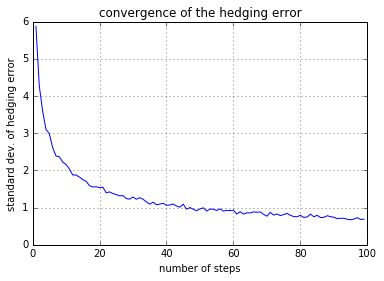

In [96]:
pyplot.plot(stepCounts, standardDeviations)
pyplot.grid(True)
pyplot.xlabel("number of steps")
pyplot.ylabel("standard dev. of hedging error")
pyplot.title("convergence of the hedging error")
pyplot.savefig("HedgingErrorConvergence.png")

## Mean of the Hedging Error

Just as a sanity check - this should be fluctuating around zero.

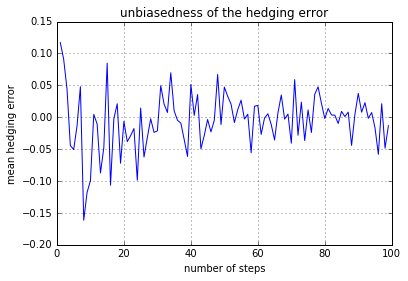

In [98]:
pyplot.plot(stepCounts, means)
pyplot.grid(True)
pyplot.xlabel("number of steps")
pyplot.ylabel("mean hedging error")
pyplot.title("unbiasedness of the hedging error")
pyplot.savefig("HedgingErrorUnbiasedness.png")